# Problem to solve: univariate time series + Imbalanced dataset Classification
### "Classification on imbalanced data" of Tensorflow references: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kepler-labelled-time-series-data/exoTest.csv
/kaggle/input/kepler-labelled-time-series-data/exoTrain.csv


In [2]:
import os
import tempfile

import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelBinarizer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Conv1D, BatchNormalization, ReLU, GlobalAveragePooling1D, Dense, Dropout, Flatten, MaxPooling1D
from keras.models import Model, Sequential
from keras.metrics import Precision, Recall
import keras.backend as K

In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

exoTest = pd.read_csv('../input/kepler-labelled-time-series-data/exoTest.csv')
exoTrain = pd.read_csv('../input/kepler-labelled-time-series-data/exoTrain.csv')

# windelta's Acknowledgements
The data presented here are cleaned and are derived from observations made by the NASA Kepler space telescope  
Over 99% of this dataset originates from **Campaign 3**  
Using Kepler Space Telescope Data to Identify an Exoplanet  
: https://www.sciencebuddies.org/science-fair-projects/project-ideas/Exoplanets_p002/exoplanets/kepler-data-exoplanet  
Campain Fields: https://archive.stsci.edu/missions-and-data/k2/campaign-fields.html#c3

In [4]:
'''
data Description
rows: a star data
columns:
    LABEL -> 2 is an exoplanet star and 1 is a non-exoplanet-star.
    FLUX.1-FLUX.3197 -> the light intensity recorded for each star, at a different point in time.
'''
print(exoTrain.dtypes)
print(exoTrain.info())
print(exoTrain.head())

LABEL          int64
FLUX.1       float64
FLUX.2       float64
FLUX.3       float64
FLUX.4       float64
              ...   
FLUX.3193    float64
FLUX.3194    float64
FLUX.3195    float64
FLUX.3196    float64
FLUX.3197    float64
Length: 3198, dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5087 entries, 0 to 5086
Columns: 3198 entries, LABEL to FLUX.3197
dtypes: float64(3197), int64(1)
memory usage: 124.1 MB
None
   LABEL   FLUX.1   FLUX.2   FLUX.3   FLUX.4   FLUX.5   FLUX.6  FLUX.7  \
0      2    93.85    83.81    20.10   -26.98   -39.56  -124.71 -135.18   
1      2   -38.88   -33.83   -58.54   -40.09   -79.31   -72.81  -86.55   
2      2   532.64   535.92   513.73   496.92   456.45   466.00  464.50   
3      2   326.52   347.39   302.35   298.13   317.74   312.70  322.33   
4      2 -1107.21 -1112.59 -1118.95 -1095.10 -1057.55 -1034.48 -998.34   

    FLUX.8  FLUX.9  ...  FLUX.3188  FLUX.3189  FLUX.3190  FLUX.3191  \
0   -96.27  -79.89  ...     -78.07    -102.15    

In [5]:
exoTrain['LABEL'].value_counts(), exoTest['LABEL'].value_counts()

(1    5050
 2      37
 Name: LABEL, dtype: int64,
 1    565
 2      5
 Name: LABEL, dtype: int64)

In [6]:
# creating target data
X_train = exoTrain.drop('LABEL', axis=1).to_numpy()
X_train = np.expand_dims(X_train, axis=2)
y_train = exoTrain['LABEL'].to_numpy()[:, np.newaxis]

X_test = exoTest.drop('LABEL', axis=1).to_numpy()
X_test = np.expand_dims(X_test, axis=2)
y_test = exoTest['LABEL'].to_numpy()[:, np.newaxis]

In [7]:
np.random.seed(42)

# shuffling data
row_index = np.arange(X_train.shape[0])
np.random.shuffle(row_index) # replace itself
trian_X = X_train[row_index]
y_train = y_train[row_index]

row_index = np.arange(X_test.shape[0])
np.random.shuffle(row_index)
X_test = X_test[row_index]
y_test = y_test[row_index]

In [8]:
valid_ratio = 0.2
split = int(X_train.shape[0]*valid_ratio)

X_valid = X_train[:split, :, :]
y_valid = y_train[:split]

X_train = X_train[split:, :, :]
y_train = y_train[split:]

## 데이터 전처리 - 정규화

In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(np.squeeze(X_train, axis=2))[:, :, np.newaxis]

X_valid = scaler.transform(np.squeeze(X_valid, axis=2))[:, :, np.newaxis]
X_test = scaler.transform(np.squeeze(X_test, axis=2))[:, :, np.newaxis]

# np.clip -> 특이값 제거
X_train = np.clip(X_train, -5, 5) # numpy.clip 함수는 어레이의 최소값, 최대값을 지정
X_valid = np.clip(X_valid, -5, 5)
X_test = np.clip(X_test, -5, 5)

# 클래스가 1, 2로 되어있어서 모델의 classifier를 헷갈리게 만듦 -> (loss < 0)를 초래
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_valid = lb.transform(y_valid)
y_test = lb.transform(y_test)

print('Training features shape:', X_train.shape)
print('Validation features shape:', X_valid.shape)
print('Test features shape:', X_test.shape)
print()

print('Training labels shape:', y_train.shape)
print('Validation labels shape:', y_valid.shape)
print('Test labels shape:', y_test.shape)

Training features shape: (4070, 3197, 1)
Validation features shape: (1017, 3197, 1)
Test features shape: (570, 3197, 1)

Training labels shape: (4070, 1)
Validation labels shape: (1017, 1)
Test labels shape: (570, 1)


In [10]:
neg0, pos0 = np.bincount(np.squeeze(y_train))
neg1, pos1 = np.bincount(np.squeeze(y_valid))
neg2, pos2 = np.bincount(np.squeeze(y_test))
neg = neg0 + neg1 + neg2
pos = pos0 + pos1 + pos2
total = neg + pos

print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 5657
    Positive: 42 (0.74% of total)



In [11]:
initial_bias = np.log([pos/neg])
initial_bias

array([-4.89552725])

# define model(sequences-to-vector LSTM)

## [custom metrics reference](https://stackoverflow.com/questions/52041931/is-there-an-optimizer-in-keras-based-on-precision-or-recall-instead-of-loss)

In [12]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

2022-03-31 06:54:57.244242: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-31 06:54:57.405177: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-31 06:54:57.405976: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-31 06:54:57.407181: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [13]:
K.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = keras.initializers.Constant(output_bias)
    
    # WaveNet version
    model = keras.models.Sequential()
    
    model.add(keras.layers.InputLayer(input_shape=[None, 1])) # [None, 1] -> (batch_size, time_steps, 1)
    for rate in (1, 2, 4, 8) * 2:
        model.add(keras.layers.Conv1D(filters=14, kernel_size=2, padding="causal",
                                      activation="relu", dilation_rate=rate))
    model.add(keras.layers.GRU(8))
    model.add(keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias))
    
    model.compile(loss=keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=metrics) 
        
    return model

model = make_model(metrics=METRICS, output_bias=initial_bias)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 14)          42        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 14)          406       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 14)          406       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 14)          406       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 14)          406       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 14)          406       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 14)          4

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [15]:
EPOCHS = 20

history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_valid, y_valid),
    verbose=1
)

2022-03-31 06:55:00.676957: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-03-31 06:55:04.684927: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


128/128 [==============================] - 24s 112ms/step - loss: 0.0424 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4041.0000 - fn: 29.0000 - accuracy: 0.9929 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0071 - val_loss: 0.0460 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1009.0000 - val_fn: 8.0000 - val_accuracy: 0.9921 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_prc: 0.0079
Epoch 2/20
128/128 [==============================] - 13s 101ms/step - loss: 0.0424 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4041.0000 - fn: 29.0000 - accuracy: 0.9929 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0071 - val_loss: 0.0460 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1009.0000 - val_fn: 8.0000 - val_accuracy: 0.9921 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_prc: 0.0079
Epoch 3/20
128/128 [==============================] - 13s 104ms/step - loss: 0.0425 - tp: 0.0000e+00 - fp: 0.00

In [16]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

## Check training history - These are useful to check for overfitting

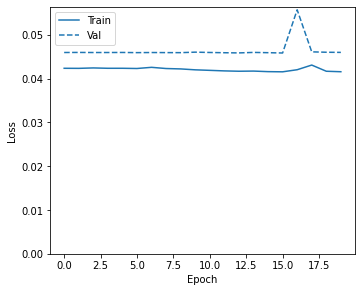

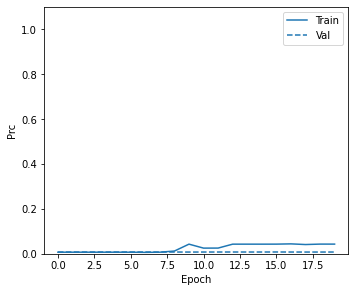

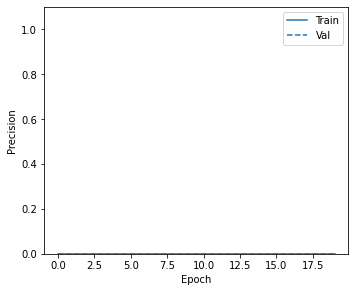

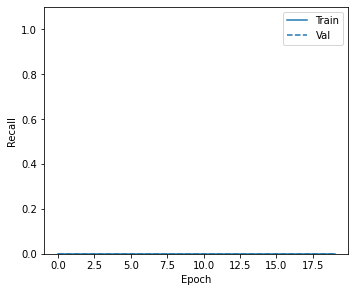

In [17]:
def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall'] # prc: Precision-Recall Curve
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1.1])
        else:
            plt.ylim([0,1.1])
        plt.legend()
        plt.show()

plot_metrics(history)

(570, 1)
loss :  0.050500717014074326
tp :  0.0
fp :  0.0
tn :  565.0
fn :  5.0
accuracy :  0.9912280440330505
precision :  0.0
recall :  0.0
auc :  0.5026549100875854
prc :  0.008818342350423336

Non-exoplanet star Detected (True Negatives):  565
Non-exoplanet star Incorrectly Detected (False Positives):  0
Exoplanet star Missed (False Negatives):  5
Correctly classified Exoplanet star (True Positives):  0
Total number of exoplanet star:  5


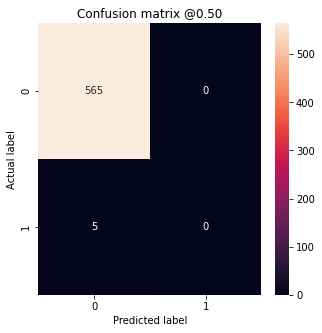

In [18]:
def plot_cm(true, pred, p=0.5):
    cm = confusion_matrix(true, pred > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Non-exoplanet star Detected (True Negatives): ', cm[0][0])
    print('Non-exoplanet star Incorrectly Detected (False Positives): ', cm[0][1])
    print('Exoplanet star Missed (False Negatives): ', cm[1][0])
    print('Correctly classified Exoplanet star (True Positives): ', cm[1][1])
    print('Total number of exoplanet star: ', np.sum(cm[1]))
    
    
train_predictions_baseline = model.predict(X_train)
test_predictions_baseline = model.predict(X_test)
print(test_predictions_baseline.shape)
    
baseline_results = model.evaluate(X_test, y_test, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)

### False negatives would allow fraudulent(사기치는) transactions  
### -> 차라리 false positives를 높이더라도, false negatives를 낮추는 것이 낫다

## Plot the ROC  
Now plot the ROC. This plot is useful because it shows, at a glance, the range of performance the model can reach just by tuning the output threshold.

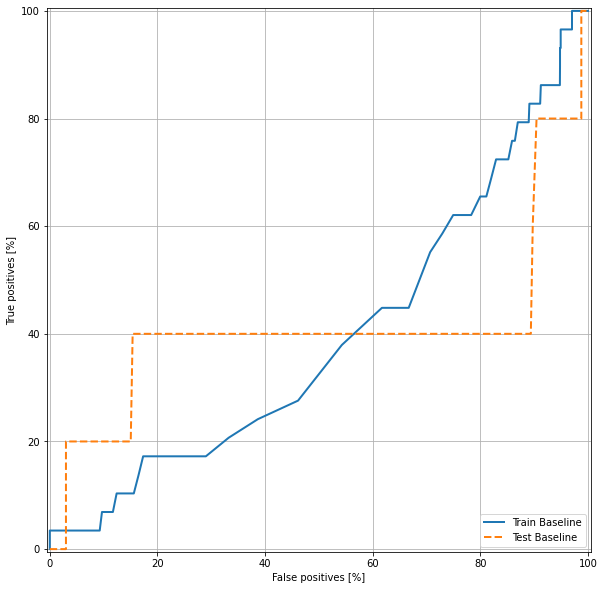

In [19]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,100.5]) # plt.xlim([-0.5,20])
    plt.ylim([-0.5,100.5]) # plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')    

plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[1], linestyle='--')
plt.legend(loc='lower right')

### Plot the AUPRC  
Now plot the AUPRC. Area under the interpolated precision-recall curve, obtained by plotting (recall, precision) points for different values of the classification threshold. Depending on how it's calculated, PR AUC may be equivalent to the average precision of the model.

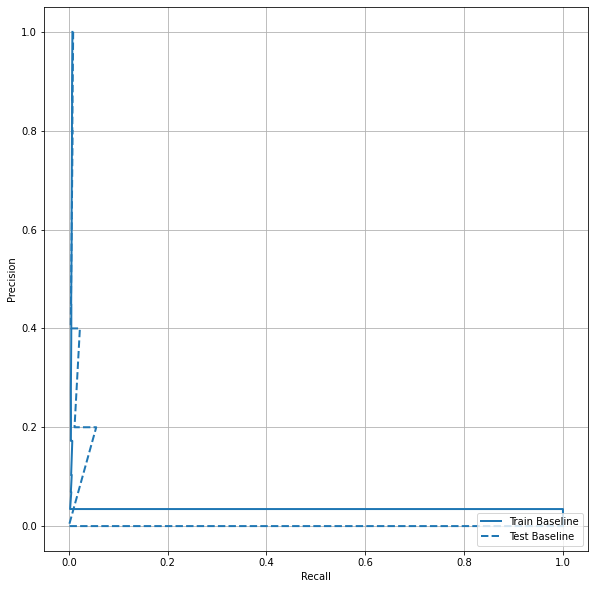

In [20]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    
plot_prc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

#### Recall is the percentage of actual positives that were correctly classified
#### It looks like the precision is relatively high, but the recall and the area under the ROC curve (AUC) aren't as high as you might like. Classifiers often face challenges when trying to maximize both precision and recall, which is especially true when working with imbalanced datasets.

## Class weights
### Calculate class weights
The goal is to identify fraudulent transactions, but you don't have very many of those positive samples to work with, so you would want to have the classifier heavily weight the few examples that are available. You can do this by passing Keras weights for each class through a parameter.   
**These will cause the model to "pay more attention" to examples from an under-represented class.**

In [21]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 67.35


### Train a model with class weights
Now try re-training and evaluating the model with class weights to see how that affects the predictions.

In [22]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping],
    # The class weights go here
    class_weight=class_weight)

Epoch 1/20
128/128 [==============================] - 17s 111ms/step - loss: 1.2107 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4606.0000 - fn: 34.0000 - accuracy: 0.9927 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5171 - prc: 0.0075 - val_loss: 0.6346 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1009.0000 - val_fn: 8.0000 - val_accuracy: 0.9921 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5059 - val_prc: 0.0080
Epoch 2/20
128/128 [==============================] - 13s 101ms/step - loss: 0.6867 - tp: 1.0000 - fp: 381.0000 - tn: 3660.0000 - fn: 28.0000 - accuracy: 0.8995 - precision: 0.0026 - recall: 0.0345 - auc: 0.3896 - prc: 0.0053 - val_loss: 0.6461 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1009.0000 - val_fn: 8.0000 - val_accuracy: 0.9921 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5050 - val_prc: 0.0079
Epoch 3/20
128/128 [==============================] - 13s 102ms/step - loss: 0.6858 - tp: 0.0000e+00 - fp: 0.0000e

In [23]:
weighted_model.save_weights(initial_weights)

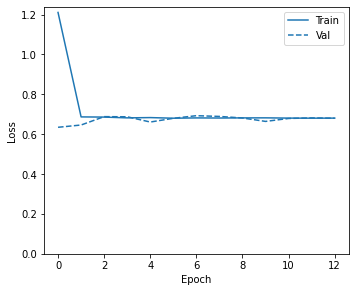

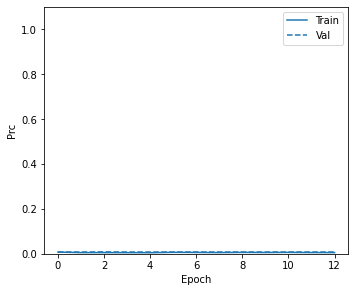

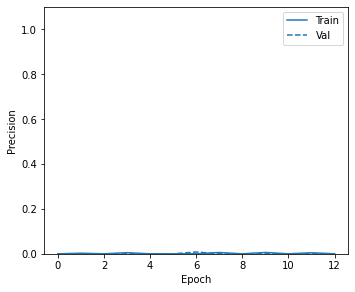

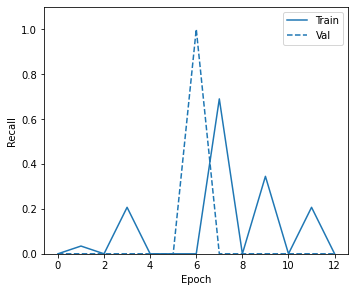

In [24]:
plot_metrics(weighted_history)

Here you can see that with class weights the accuracy and precision are lower because there are more false positives, but conversely the recall and AUC are higher because the model also found more true positives.  
**Despite having lower accuracy, this model has higher recall (and identifies more fraudulent transactions)**.

loss :  0.050500717014074326
tp :  0.0
fp :  0.0
tn :  565.0
fn :  5.0
accuracy :  0.9912280440330505
precision :  0.0
recall :  0.0
auc :  0.5026549100875854
prc :  0.008818342350423336

Non-exoplanet star Detected (True Negatives):  565
Non-exoplanet star Incorrectly Detected (False Positives):  0
Exoplanet star Missed (False Negatives):  5
Correctly classified Exoplanet star (True Positives):  0
Total number of exoplanet star:  5


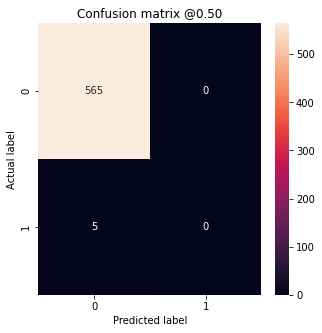

In [25]:
train_predictions_weighted = model.predict(X_train)
test_predictions_weighted = model.predict(X_test)
    
weighted_baseline_results = model.evaluate(X_test, y_test, verbose=0)
for name, value in zip(model.metrics_names, weighted_baseline_results):
    print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_weighted)

## Plot the ROC  
An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds.  
This curve plots two parameters: True Positive Rate. False Positive Rate

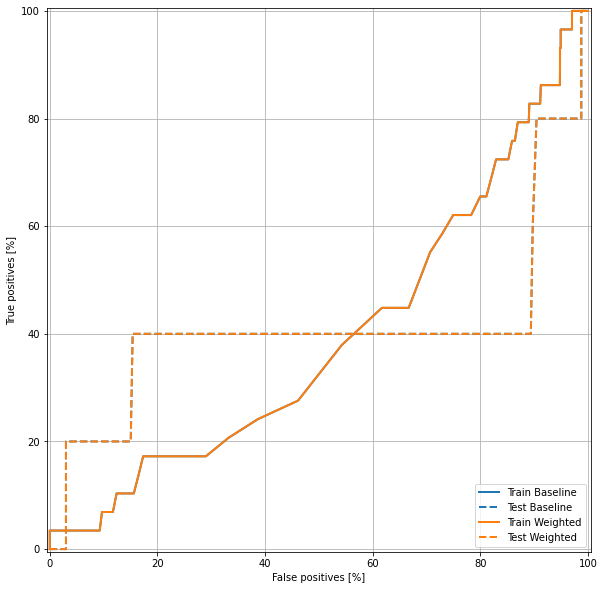

In [26]:
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", y_test, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

## Plot the AUPRC  
The area under the precision-recall curve (AUPRC) is a useful performance metric for imbalanced data in a problem setting where you care a lot about finding the positive examples.

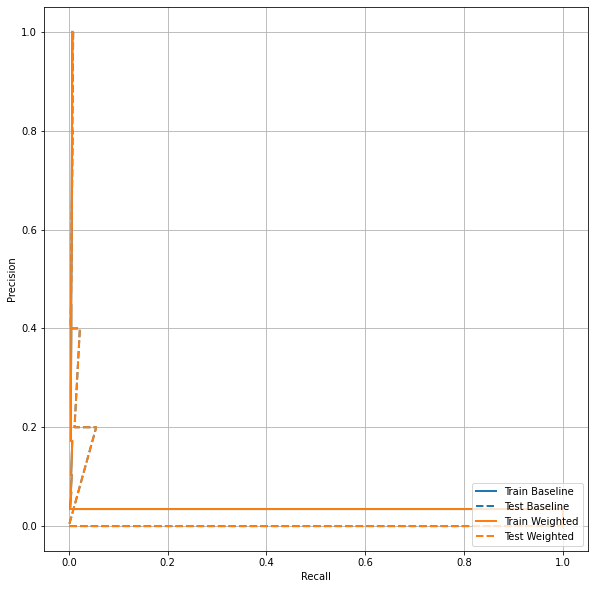

In [27]:
plot_prc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", y_test, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

## Oversample the minority class
A related approach would be to resample the dataset by oversampling the minority class.

### Using NumPy
You can balance the dataset manually by choosing the right number of random indices from the positive examples:

In [28]:
def oversample_minority(train_features, train_labels):
    bool_y_train = np.squeeze(train_labels) !=0

    pos_features = train_features[bool_y_train]
    neg_features = train_features[~bool_y_train]

    pos_labels = train_labels[bool_y_train]
    neg_labels = train_labels[~bool_y_train]
    ids = np.arange(len(pos_features))
    choices = np.random.choice(ids, len(neg_features))

    res_pos_features = pos_features[choices]
    res_pos_labels = pos_labels[choices]
    resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
    resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

    order = np.arange(len(resampled_labels))
    np.random.shuffle(order)
    resampled_features  = resampled_features[order]
    resampled_labels  = resampled_labels[order]
    return resampled_features, resampled_labels


In [29]:
X_train_resampled, y_train_resampled = oversample_minority(X_train, y_train)
X_valid_resampled, y_valid_resampled = oversample_minority(X_valid, y_valid)

X_train_resampled.shape, y_train_resampled.shape, X_valid_resampled.shape, y_valid_resampled.shape

((8082, 3197, 1), (8082, 1), (2018, 3197, 1), (2018, 1))

#### high training accuracy & low validation acrruacy -> overfitting
- The hypothesis function you are using is too complex that your model perfectly fits the training data but fails to do on test/validation data.
- The number of learning parameters in your model is way too big that instead of generalizing the examples , your model learns those examples and hence the model performs badly on test/validation data.

#### overfitting 완화 - steps_per_epoch
steps_per_epoch is batches of samples to train. It is used to define how many batches of samples to use in one epoch. It is used to declaring one epoch finished and starting the next epoch  
- Because training is easier on the balanced data, the above training procedure may overfit quickly.  
- So break up the epochs to give the tf.keras.callbacks.EarlyStopping finer control over when to stop training.

#### overfitting 완화 다른 방법
- Use a simple cost and loss function.
- Use regulation which helps in reducing over-fitting i.e Dropout.
- Reduce the number of learning parameters in your model.

In [30]:
EPOCHS=100
resampled_model = make_model(metrics=METRICS, output_bias=None) 
# resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    X_train_resampled,
    y_train_resampled,
    epochs=10*EPOCHS,
    steps_per_epoch=20, # steps * batch_size = n_samples * epochs
    callbacks=[early_stopping],
    validation_data=(X_valid_resampled, y_valid_resampled))


Epoch 1/1000
20/20 [==============================] - 12s 422ms/step - loss: 0.6928 - tp: 3804.0000 - fp: 3826.0000 - tn: 780.0000 - fn: 242.0000 - accuracy: 0.5298 - precision: 0.4986 - recall: 0.9402 - auc: 0.5658 - prc: 0.5287 - val_loss: 0.6931 - val_tp: 1009.0000 - val_fp: 1006.0000 - val_tn: 3.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.5015 - val_precision: 0.5007 - val_recall: 1.0000 - val_auc: 0.4995 - val_prc: 0.4926
Epoch 2/1000
20/20 [==============================] - 7s 344ms/step - loss: 0.6888 - tp: 2057.0000 - fp: 1779.0000 - tn: 2262.0000 - fn: 1984.0000 - accuracy: 0.5344 - precision: 0.5362 - recall: 0.5090 - auc: 0.5390 - prc: 0.5660 - val_loss: 0.6936 - val_tp: 876.0000 - val_fp: 840.0000 - val_tn: 169.0000 - val_fn: 133.0000 - val_accuracy: 0.5178 - val_precision: 0.5105 - val_recall: 0.8682 - val_auc: 0.5429 - val_prc: 0.5318
Epoch 3/1000
20/20 [==============================] - 7s 346ms/step - loss: 0.6820 - tp: 2168.0000 - fp: 1632.0000 - tn: 2409.0000 - fn: 18

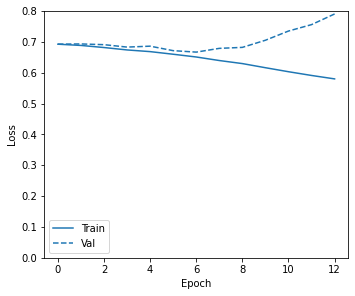

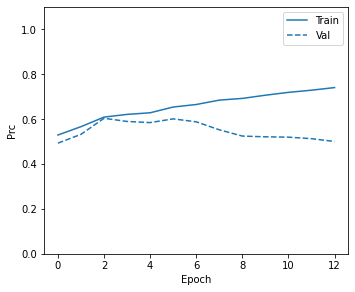

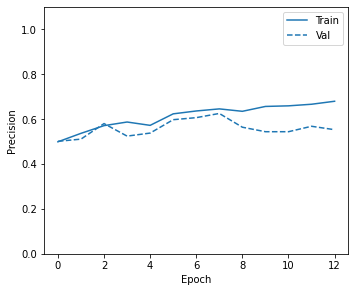

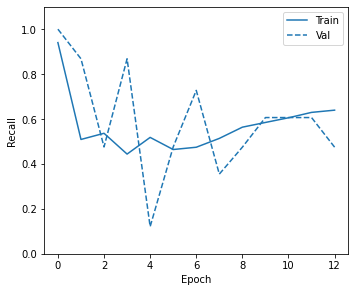

In [31]:
plot_metrics(resampled_history)

loss :  0.6937695145606995
tp :  3.0
fp :  128.0
tn :  437.0
fn :  2.0
accuracy :  0.7719298005104065
precision :  0.022900763899087906
recall :  0.6000000238418579
auc :  0.7500885128974915
prc :  0.03180950507521629

Non-exoplanet star Detected (True Negatives):  437
Non-exoplanet star Incorrectly Detected (False Positives):  128
Exoplanet star Missed (False Negatives):  2
Correctly classified Exoplanet star (True Positives):  3
Total number of exoplanet star:  5


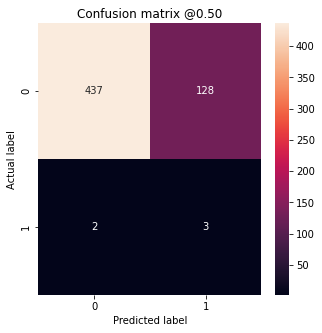

In [32]:
train_predictions_resampled = resampled_model.predict(X_train)
test_predictions_resampled = resampled_model.predict(X_test)

resampled_results = resampled_model.evaluate(X_test, y_test,
                                            verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
    print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_resampled)

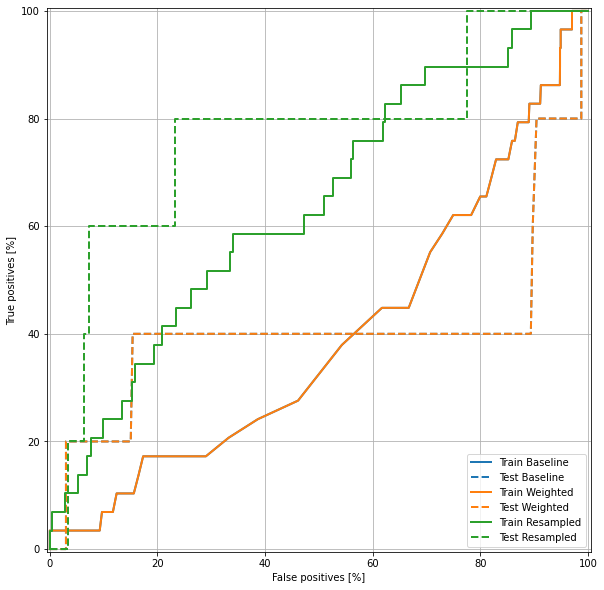

In [33]:
# Plot the ROC
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", y_test, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", y_train, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", y_test, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

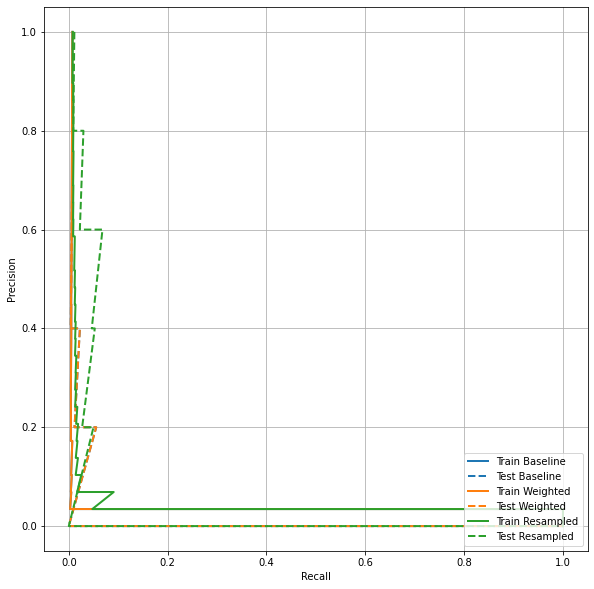

In [34]:
# Plot the AUPRC
plot_prc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", y_test, test_predictions_weighted, color=colors[1], linestyle='--')

plot_prc("Train Resampled", y_train, train_predictions_resampled, color=colors[2])
plot_prc("Test Resampled", y_test, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');